In [1]:
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement

import cv2
import os
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '..')

from web_interaction.main import open_game, start_game, wait_loading, insert_user_stories_from_image
from web_interaction.main import fill_game_main_info_from_image
from web_interaction.main import apply_decompose_action, apply_user_story_action
from game.game import ProductOwnerGame
from game.userstory_card.userstory_card_info import UserStoryCardInfo
from environment.backlog_env import BacklogEnv
from environment.environment import ProductOwnerEnv
from environment.reward_sytem.base_reward_system import BaseRewardSystem
from environment.userstory_env import UserstoryEnv
import image_parser

from pipeline.study_agent import load_dqn_agent
from single_color_storage import SingleColorStorage

In [3]:
driver = open_game()

iframe = driver.find_element(by=By.ID, value='game_drop')
height = iframe.rect["height"]  # 540
width = iframe.rect["width"]  # 960

wait_loading(iframe)

start_game(driver, iframe)

In [4]:
iframe.screenshot('iframe.png')

image = cv2.imread('iframe.png')

In [5]:
game = ProductOwnerGame()
context = game.context

context.is_new_game = False

available_developers_count = 2
current_rooms_counter = 1
blank_sprint_counter = 0

In [6]:
insert_user_stories_from_image(game, image)

game.userstories.stories_list

[S l:0.045 c:2.0]

In [7]:
fill_game_main_info_from_image(game, image)

print('Sprint', game.context.current_sprint)
print('Sprint hours', game.context.current_sprint_hours)
print('Money', game.context.get_money())
print('Loyalty', game.context.get_loyalty())
print('Customers', game.context.customers)
print('Credit', game.context.credit)

Sprint 4.0
Sprint hours 0.0
Money 33000.0
Loyalty 4.0
Customers 25.0
Credit 273000.0


In [8]:
userstory_env = UserstoryEnv(2, 0, 0)
backlog_env = BacklogEnv(6, 0, 0, 0, 0, 0)
reward_system = BaseRewardSystem(config={})
env = ProductOwnerEnv(userstory_env, backlog_env, with_info=True, reward_system=reward_system)
env.game = game

In [9]:
agent = load_dqn_agent('../models/credit_start_model.pt')

In [17]:
from game.backlog_card.backlog_card import Card
from game.backlog_card.card_info import CardInfo
from web_interaction.main import click_on_card, select_backlog_board, click_board_button


def find_backlog_card_position(card: Card, image: cv2.typing.MatLike):
    card: CardInfo = card.info
    backlog_cards = image_parser.get_backlog(image)
    for color, hours, position in backlog_cards:
        if color != card.color:
            continue
        if hours != card.hours:
            continue
        return position


def apply_backlog_card_action(
    action: int, driver, iframe: WebElement, env: ProductOwnerEnv
):
    print("Start moving backlog card")
    select_backlog_board(driver, iframe, width, height)

    filename = "backlog_board.png"
    iframe.screenshot(filename)
    backlog_board_image = cv2.imread(filename)
    # os.remove(filename)

    card = env.backlog_env.get_card(action)
    print('Selected card', card)
    position = find_backlog_card_position(card, backlog_board_image)
    print('Found at position', position)

    click_on_card(driver, iframe, *position)

    print('Clicked on card')

    env._perform_action_backlog_card(action)


def apply_start_sprint_action(driver, iframe: WebElement, width: int, height: int, env: ProductOwnerEnv):
    print('Start new sprint')

    select_backlog_board(driver, iframe, width, height)

    time.sleep(5)
    
    click_board_button(driver, iframe, width, height)

    env._perform_start_sprint_action()

    time.sleep(2)

    filename = 'game_state.png'
    iframe.screenshot(filename)
    game_image = cv2.imread(filename)
    # os.remove(filename)

    fill_game_main_info_from_image(env.game, game_image)


def apply_web_action(action: int, driver, iframe: WebElement, env: ProductOwnerEnv):
    if action == 0:  # start sprint

        apply_start_sprint_action(driver, iframe, width, height, env)

        return

    if action == 1:  # decompose

        apply_decompose_action(driver, iframe, width, height, env)

        return


    if action >= env.meta_action_dim:

        action -= env.meta_action_dim


    if action < env.userstory_env.max_action_num:

        apply_user_story_action(action, driver, iframe, env)

        return


    action -= env.userstory_env.max_action_num

    if action < env.backlog_env.backlog_max_action_num:

        apply_backlog_card_action(action, driver, iframe, env)


    raise Exception(f"Unknown action: {action}")

In [15]:
state = env._get_state()
print(state)

info = env.get_info()
print(info)

action = agent.get_action(state, info)
print(action)

[ 4.     0.33  25.     4.     2.73   2.     1.     2.     2.     0.
  1.     0.     0.     1.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     8.     8.     1.
  0.     0.045  2.     3.     8.     8.     1.     0.     0.045  2.
  3.     8.     8.     1.     0.     0.045  2.     3.     9.     9.
  1.     0.     0.045  2.     3.     8.     8.     1.     0.     0.045
  2.     3.     7.     7.     1.     0.     0.045  2.     3.   ]
{'actions': [0, 9, 10, 11, 12, 13, 14]}
12


Start moving backlog card
Selected card <game.backlog_card.backlog_card.Card object at 0x000002249CDC3FD0>


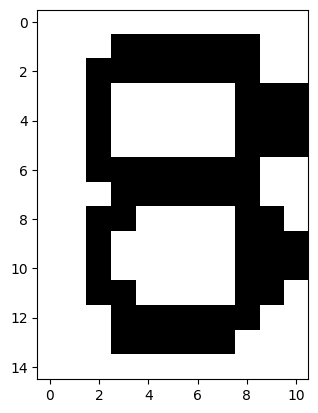

Found at position (725, 183)
Clicked on card


Exception: Unknown action: 3

In [18]:
time.sleep(2)
apply_web_action(action, driver, iframe, env)

In [13]:
iframe.rect

{'height': 540, 'width': 960, 'x': 29.600000381469727, 'y': 20}

In [33]:
driver.quit()